# Train a model on Parkinson telemonitoring data

## Retrieve data

In [1]:
#pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
from ucimlrepo import fetch_ucirepo 

  
# fetch dataset 
parkinson = fetch_ucirepo(id=189)
df = parkinson.data
  
# data (as pandas dataframes) 
X = parkinson.data.features 
y = parkinson.data.targets 

y_motor = y.motor_UPDRS	
y_total = y.total_UPDRS
  
# variable information 
parkinson.variables

ConnectionError: Error connecting to server

In [10]:
def load_parkinson_updrs_data(data_file_path):
    df = pd.read_csv(data_file_path)

    target_columns = ['total_UPDRS', 'motor_UPDRS']
    target_df = df[target_columns]
    feature_df = df.drop(columns=target_columns)

    return {
        'data': {
            'features': feature_df,
            'targets': target_df
        },
        'feature_names': feature_df.columns.tolist(),
        'target_names': target_df.columns.tolist()
    }

dataset = load_parkinson_updrs_data('../dataset_Parkinson/parkinsons_updrs.data')

X = dataset['data']['features'].drop(columns=["subject#", "test_time"])
y = dataset['data']['targets']
y_total = y['total_UPDRS']

In [11]:
df = pd.concat([X, y], axis=1)
df

age  sex  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  Jitter:DDP  \
0      72    0    0.00662     0.000034     0.00401      0.00317     0.01204   
1      72    0    0.00300     0.000017     0.00132      0.00150     0.00395   
2      72    0    0.00481     0.000025     0.00205      0.00208     0.00616   
3      72    0    0.00528     0.000027     0.00191      0.00264     0.00573   
4      72    0    0.00335     0.000020     0.00093      0.00130     0.00278   
...   ...  ...        ...          ...         ...          ...         ...   
5870   61    0    0.00406     0.000031     0.00167      0.00168     0.00500   
5871   61    0    0.00297     0.000025     0.00119      0.00147     0.00358   
5872   61    0    0.00349     0.000025     0.00152      0.00187     0.00456   
5873   61    0    0.00281     0.000020     0.00128      0.00151     0.00383   
5874   61    0    0.00282     0.000021     0.00135      0.00166     0.00406   

      Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  \
0     0.02565        0.230       0.01438       0.01309        0.01662   
1     0.02024        0.179       0.00994       0.01072        0.01689   
2     0.01675        0.181       0.00734       0.00844        0.01458   
3     0.02309        0.327       0.01106       0.01265        0.01963   
4     0.01703        0.176       0.00679       0.00929        0.01819   
...       ...          ...           ...           ...            ...   
5870  0.01896        0.160       0.00973       0.01133        0.01549   
5871  0.02315        0.215       0.01052       0.01277        0.01904   
5872  0.02499        0.244       0.01371       0.01456        0.01877   
5873  0.01484        0.131       0.00693       0.00870        0.01307   
5874  0.01907        0.171       0.00946       0.01154        0.01470   

      Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  total_UPDRS  \
0         0.04314  0.014290  21.640  0.41888  0.54842  0.16006       34.398   
1         0.02982  0.011112  27.183  0.43493  0.56477  0.10810       34.894   
2         0.02202  0.020220  23.047  0.46222  0.54405  0.21014       35.389   
3         0.03317  0.027837  24.445  0.48730  0.57794  0.33277       35.810   
4         0.02036  0.011625  26.126  0.47188  0.56122  0.19361       36.375   
...           ...       ...     ...      ...      ...      ...          ...   
5870      0.02920  0.025137  22.369  0.64215  0.55314  0.21367       33.485   
5871      0.03157  0.011927  22.886  0.52598  0.56518  0.12621       32.988   
5872      0.04112  0.017701  25.065  0.47792  0.57888  0.14157       32.495   
5873      0.02078  0.007984  24.422  0.56865  0.56327  0.14204       32.007   
5874      0.02839  0.008172  23.259  0.58608  0.57077  0.15336       31.513   

      motor_UPDRS  
0          28.199  
1          28.447  
2          28.695  
3          28.905  
4          29.187  
...           ...  
5870       22.485  
5871       21.988  
5872       21.495  
5873       21.007  
5874       20.513  

[5875 rows x 20 columns]

### Train model

   age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0   72     5.6431    0.00662     0.000034     0.00401      0.00317   
1   72    12.6660    0.00300     0.000017     0.00132      0.00150   
2   72    19.6810    0.00481     0.000025     0.00205      0.00208   
3   72    25.6470    0.00528     0.000027     0.00191      0.00264   
4   72    33.6420    0.00335     0.000020     0.00093      0.00130   

   Jitter:DDP  Shimmer  Shimmer(dB)  Shimmer:APQ3  ...  Shimmer:APQ11  \
0     0.01204  0.02565        0.230       0.01438  ...        0.01662   
1     0.00395  0.02024        0.179       0.00994  ...        0.01689   
2     0.00616  0.01675        0.181       0.00734  ...        0.01458   
3     0.00573  0.02309        0.327       0.01106  ...        0.01963   
4     0.00278  0.01703        0.176       0.00679  ...        0.01819   

   Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  sex  motor_UPDRS  \
0      0.04314  0.014290  21.640  0.41888  0.54842  0.16006

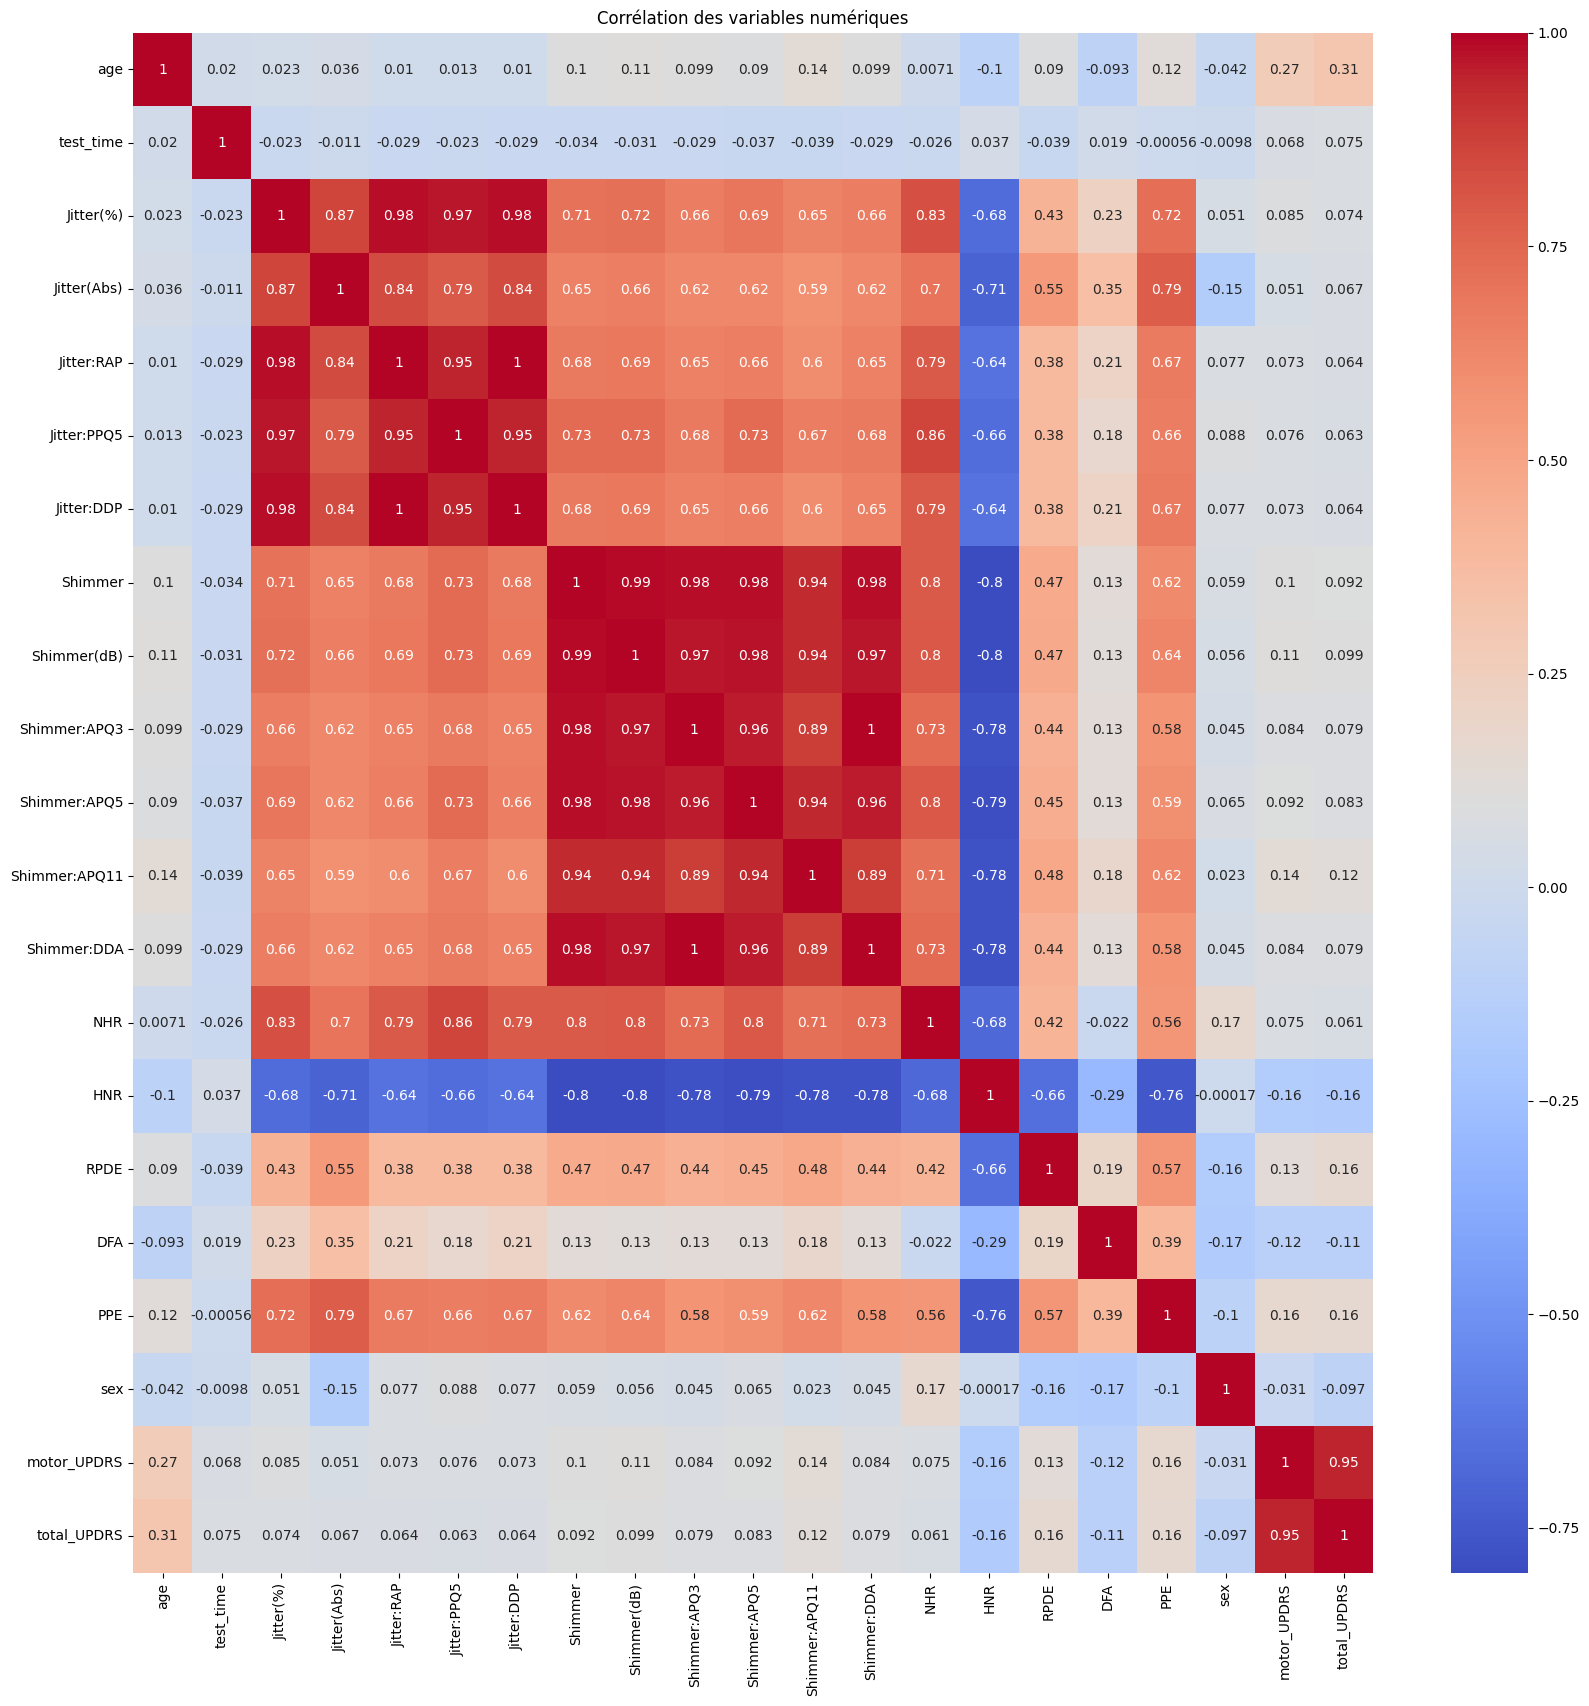

In [5]:
# Exploration minimale
print(df.head())
print(df.info())
print(df.describe())

# sns.pairplot(df.sample(200), diag_kind='kde')
# plt.suptitle("Pairplot de l'échantillon", y=1.02)
# plt.show()
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Corrélation des variables numériques")
plt.show()

In [9]:
# Prétraitement : uniquement numérique, donc normalisation
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

In [12]:
# Modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Entraînement et évaluation
trained_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n=== {name} ===")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    
    trained_models[name] = pipeline


=== LinearRegression ===
RMSE: 9.70
R² Score: 0.15

=== RandomForest ===
RMSE: 2.96
R² Score: 0.92

=== XGBoost ===
RMSE: 3.35
R² Score: 0.90


# Explicabilité globale

Le Random Forest ayant les meilleures performances, nous allons appliquer le modèle RandomForestRegressor

In [13]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline["preprocessor"].transform(X_train)
X_test_transformed = pipeline["preprocessor"].transform(X_test)

y_pred = pipeline.predict(X_test)
print(f"Random Forest Regressor - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Random Forest Regressor - R² Score: {r2_score(y_test, y_pred):.2f}")

Random Forest Regressor - RMSE: 2.96
Random Forest Regressor - R² Score: 0.92


## Explicabilité SHAP

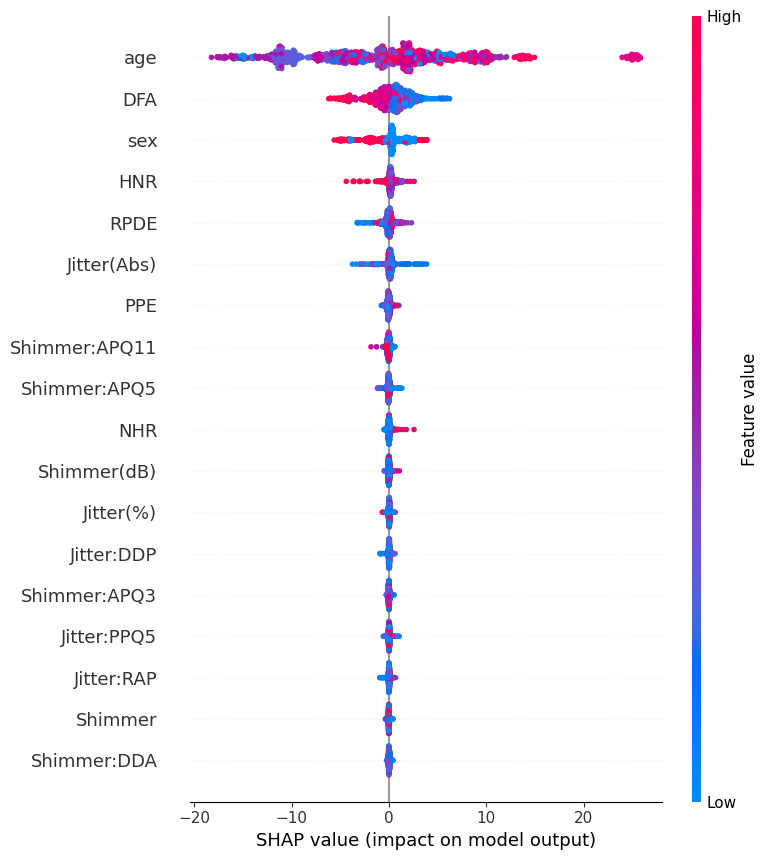

In [14]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=X.columns)

In [15]:
import shap
import ipywidgets as widgets
from IPython.display import display, HTML

shap.initjs()

# Force plot interactif
def show_force_plot(index):
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[index].values,
        features=X_test_transformed[index],
        feature_names=X.columns,
        matplotlib=False  # version JavaScript interactive
    )
    
    html = f"""
    <div style='background-color:white;padding:10px'>
        {force_plot.html()}
    </div>
    """ # fond blanc
    display(HTML(html))

# Slider pour choisir l’index (la ligne sur laquelle appliquer le SHAP local)
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(X_test_transformed) - 1,
    step=1,
    description='Index:',
    continuous_update=False
)

widgets.interact(show_force_plot, index=index_slider);


ModuleNotFoundError: No module named 'ipywidgets'

## Explicabilité Partial Dependency Plot

Le PdP peut directement prendre une pipeline en paramètre, pas besoin d'utiliser `X_train_transformed` et `X_train_transformed`

In [28]:
from saan_xai.pdp import plot_partial_dependence_interactive

plot_partial_dependence_interactive(
    pipeline=pipeline,
    X_test=X_test,
    features=list(X.columns),
    kind="average",
    grid_resolution=50,
    figsize=(7,4)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

## Prédiction ALE

Pour la prédiction ALE, deux librairies sont testées et comparées : `PyALE`et `alibi`

### PyALE

La librairie PyALE peut directement recevoir en input une pipeline sklearn, ce qui évite de devoir décomposer les étapes de la pipeline.

L'affichage d'un intervalle de confiance est également possible via les paramètres `include_CI`et `C`.

Ici nous réalisons un graphique par feature. Pour éviter de trop surcharger le notebook, seules les 7 poremières features sont affichées.


In [29]:
from saan_xai.ale import plot_ale_interactive

plot_ale_interactive(
    model=pipeline,
    X_test=X_test,
    features=None,  # None pour toutes
    grid_size=50,
    include_CI=True,
    C=0.95,
    figsize=(10, 6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

### Alibi

Avec Alibi, nous devons décomposer notre objet pipeline, car il ne prend que les modèles sklearn.

De plus, le package alibi ne prend pas en charge l'affichage des intervalles de confiance, ou la distribution des différentes features.

Enfin, pour pouvoir l'importer, il vous faut une version de numpy inférieur à 2, ce qui peut être contraignant sur le reste de votre projet.

In [30]:
from saan_xai.ale import plot_alibi_ale_interactive

plot_alibi_ale_interactive(
    model=pipeline["regressor"],
    X_test=pipeline["preprocessor"].transform(X_test),
    features=X_test.columns,  # or None for all features if X_test is a dataframe
    figsize=(10,6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

## LOFO

In [10]:
import matplotlib.pyplot as plt
from lofo import LOFOImportance, Dataset, plot_importance, FLOFOImportance

c:\Users\doria\Documents\Mathilde\Fil rouge\fil_rouge_env\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/20 [00:00<?, ?it/s]

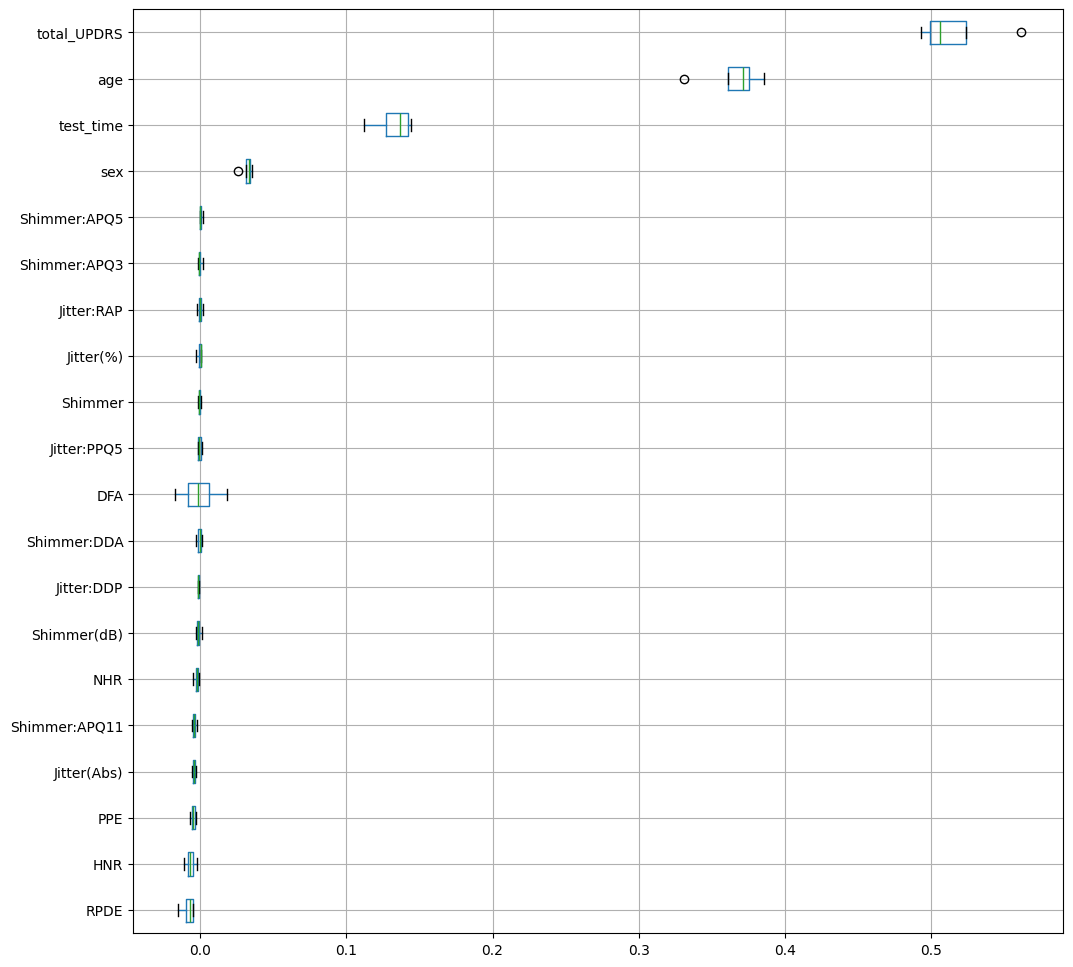

In [15]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4, shuffle=True, random_state=42)
dataset = Dataset(df=df, target="motor_UPDRS", features=[col for col in df.columns if col != "motor_UPDRS"])

lofo_imp = LOFOImportance(dataset, 
                          cv=cv, 
                          model=RandomForestRegressor(n_estimators=100, random_state=42), 
                          scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

plot_importance(importance_df, figsize=(12, 12), kind="box")

  0%|          | 0/19 [00:00<?, ?it/s]

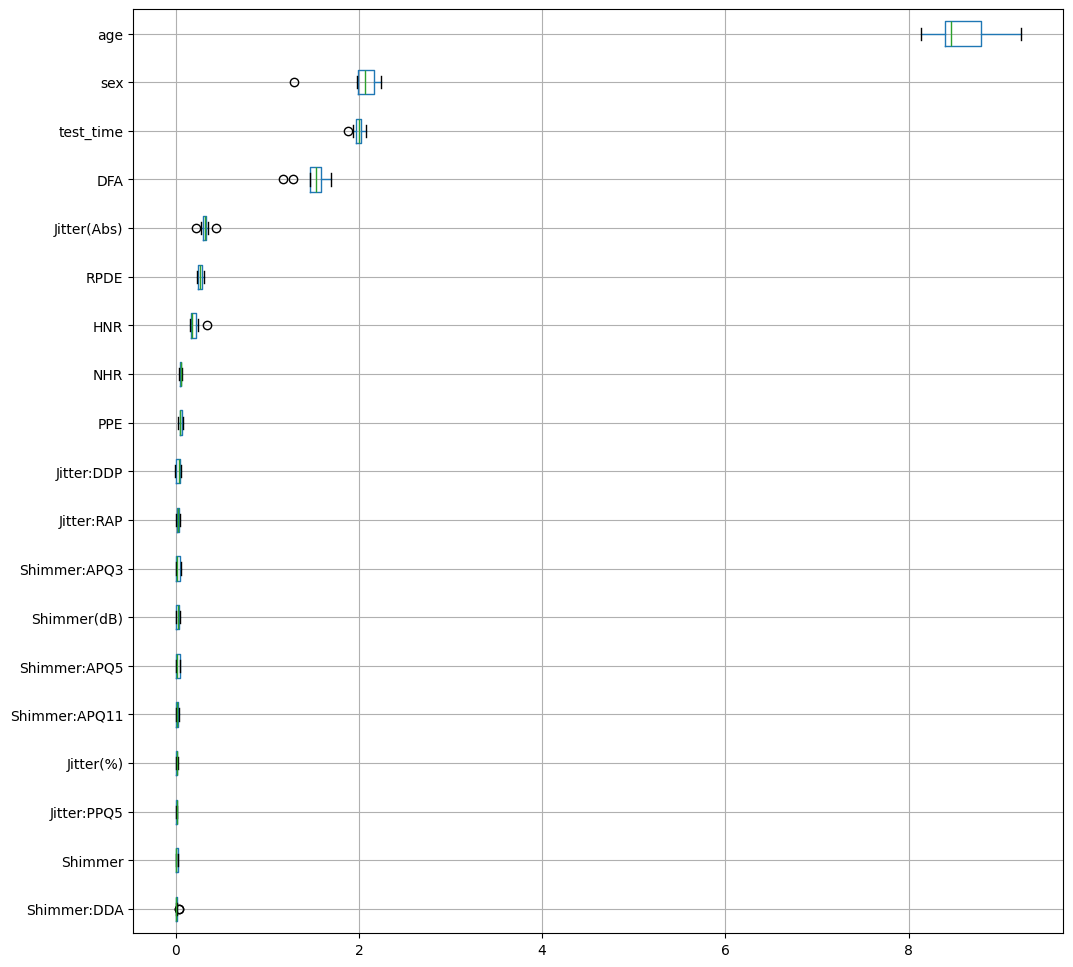

In [11]:
flofo_imp = FLOFOImportance(trained_model=pipeline, validation_df=pd.concat([X_test, y_test], axis=1), 
                           features=X_test.columns,
                           target = "total_UPDRS",
                           scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df2 = flofo_imp.get_importance()

plot_importance(importance_df2, figsize=(12, 12), kind="box")

### **Local Methods**

#### **Lime** - Local

In [40]:
# Prétraitement
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

# Modèle XGBoost (on le prendra pour SHAP)
rf_model =RandomForestRegressor(n_estimators=100, random_state=42)

# Prétraitement séparé pour retrouver les données transformées
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Split on y_total
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Entraînement
rf_model.fit(X_train_transformed, y_train)

# Prédiction et évaluation
y_pred = rf_model.predict(X_test_transformed)
print(f"RandomForest - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"RandomForest - R² Score: {r2_score(y_test, y_pred):.2f}")

RandomForest - RMSE: 2.96
RandomForest - R² Score: 0.92


In [41]:
from lime.lime_tabular import LimeTabularExplainer

instance_idx = 2  # Indice de l'instance à expliquer
instance = X_test.values[instance_idx]

# Création de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train.values,
    mode='regression',
    feature_names=X_train_transformed.columns.values.tolist(),  
    verbose=True,
)

# Explication locale
exp = explainer.explain_instance(instance,
                                rf_model.predict,
                                )


display(HTML('''
    <style>
        .lime {
            background-color: white !important;
        }
    </style>
'''))
# Affichage de l'explication
exp.show_in_notebook()


Intercept 32.9489861276416
Prediction_local [26.96365331]
Right: 15.280730000000004


In [42]:
from collections import defaultdict

importance_scores = defaultdict(list)

for i in range(len(X_test)):  # or more samples
    exp = explainer.explain_instance(X_test.iloc[i], rf_model.predict)
    for feature, weight in exp.as_list():
        importance_scores[feature].append(abs(weight))

# Compute average importance
avg_importance = {k: np.mean(v) for k, v in importance_scores.items()}
sorted_importance = sorted(avg_importance.items(), key=lambda x: -x[1])

print("Approximate global feature importance (LIME-based):")
for feature, score in sorted_importance:
    print(f"{feature}: {score:.3f}")

Intercept 30.131763017084186
Prediction_local [35.77905175]
Right: 39.68701999999999
Intercept 32.66668587129983
Prediction_local [27.97311764]
Right: 13.265483999999999
Intercept 33.259841252966304
Prediction_local [27.08682803]
Right: 15.280730000000004
Intercept 32.918801074130236
Prediction_local [27.13742655]
Right: 18.619500000000027
Intercept 31.832710458181985
Prediction_local [30.24522808]
Right: 31.121299999999998
Intercept 32.656362203982354
Prediction_local [28.45008924]
Right: 25.951099999999983
Intercept 30.62428555133696
Prediction_local [33.69280491]
Right: 19.43515999999999
Intercept 30.728558485323912
Prediction_local [34.24454122]
Right: 47.977219999999996
Intercept 30.655755506728475
Prediction_local [34.47212291]
Right: 24.66481
Intercept 32.292524865595674
Prediction_local [29.01302115]
Right: 38.00104
Intercept 32.32289266746934
Prediction_local [28.97590523]
Right: 20.374570000000002
Intercept 30.198020487957606
Prediction_local [35.01653573]
Right: 38.249539999

In [46]:
sorted_items

[('65.00 < age <= 72.00', 5.031188277898539),
 ('58.00 < age <= 65.00', 4.187163092344675),
 ('age <= 58.00', 4.0170926496884745),
 ('age > 72.00', 3.321296375564259),
 ('DFA > 0.71', 1.8729597295939873),
 ('DFA <= 0.60', 0.8692560447987252),
 ('0.60 < DFA <= 0.64', 0.8248301767460395),
 ('HNR > 24.44', 0.8053127616240144),
 ('NHR > 0.03', 0.4950050819934592),
 ('19.37 < HNR <= 21.91', 0.43844007768506255),
 ('21.91 < HNR <= 24.44', 0.4344428585952253),
 ('HNR <= 19.37', 0.4054780695530872),
 ('0.02 < Shimmer:APQ11 <= 0.03', 0.40233336554118954),
 ('0.02 < Shimmer:APQ11 <= 0.02', 0.3963129014702151),
 ('Shimmer:APQ11 <= 0.02', 0.39588429653824353),
 ('0.01 < NHR <= 0.02', 0.39352585882185914),
 ('0.64 < DFA <= 0.71', 0.39185935299348934),
 ('0.01 < Shimmer:APQ3 <= 0.02', 0.3911527025170114),
 ('Jitter:PPQ5 <= 0.00', 0.3909014243857638),
 ('Jitter(Abs) <= 0.00', 0.3904536510421742),
 ('NHR <= 0.01', 0.38997424443180584),
 ('0.03 < Shimmer <= 0.04', 0.38273416279527867),
 ('Shimmer:APQ5 

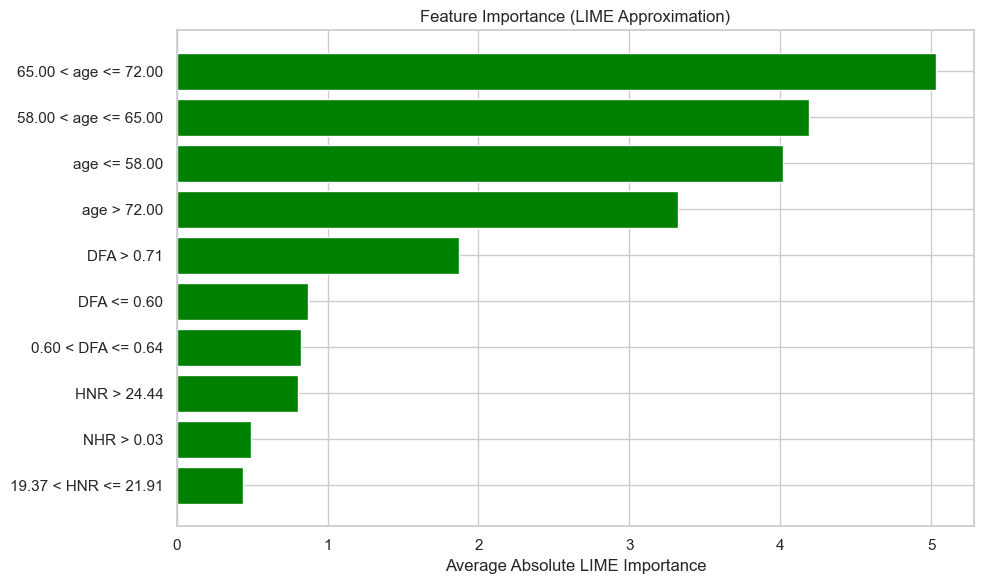

In [43]:
# Sort and plot
sorted_items = sorted(avg_importance.items(), key=lambda x: -x[1])
features, importances = zip(*sorted_items[:10])

plt.figure(figsize=(10, 6))
plt.barh(features[::-1], importances[::-1], color='green')
plt.xlabel("Average Absolute LIME Importance")
plt.title("Feature Importance (LIME Approximation)")
plt.tight_layout()
plt.show()

Intercept 30.068829028916106
Prediction_local [36.01287868]
Right: 39.68701999999999
Intercept 32.275687723497896
Prediction_local [29.2803573]
Right: 13.265483999999999
Intercept 33.08657710922549
Prediction_local [26.75307883]
Right: 15.280730000000004
Intercept 32.95421249972331
Prediction_local [26.50821181]
Right: 18.619500000000027
Intercept 32.21417174636256
Prediction_local [30.07234247]
Right: 31.121299999999998
Intercept 33.22430711542219
Prediction_local [26.33685547]
Right: 25.951099999999983
Intercept 30.02761743829878
Prediction_local [36.1217964]
Right: 19.43515999999999
Intercept 30.062534158518698
Prediction_local [35.41930823]
Right: 47.977219999999996
Intercept 31.29263154563527
Prediction_local [31.94760422]
Right: 24.66481
Intercept 32.693161902925404
Prediction_local [27.93738893]
Right: 38.00104
Intercept 32.273605501343596
Prediction_local [29.1875601]
Right: 20.374570000000002
Intercept 29.801363849358115
Prediction_local [36.30284172]
Right: 38.249539999999996

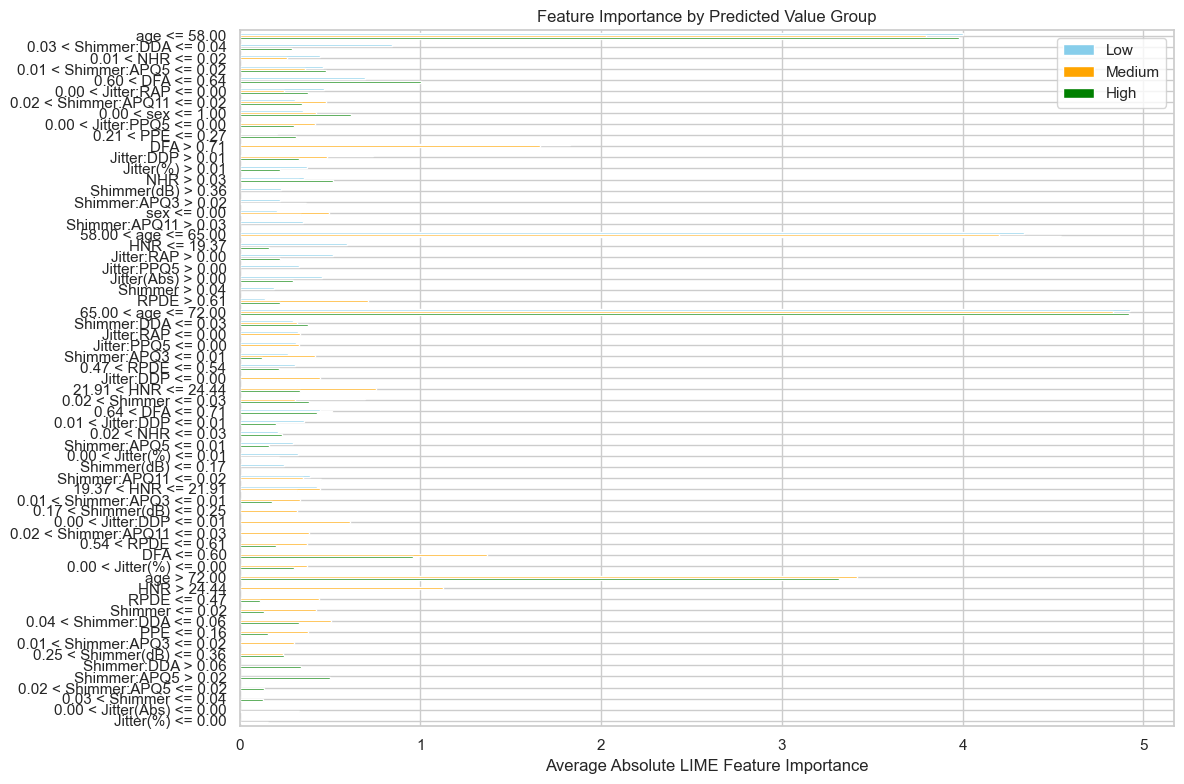

Intercept 33.58539863277838
Prediction_local [26.71459181]
Right: 15.280730000000004


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming you already have:
# rf_model (your trained regression model)
# X_train, X_test (pandas DataFrames)
# X_train_transformed.columns.values.tolist() for feature names

# Create the explainer
explainer = LimeTabularExplainer(
    X_train.values,
    mode='regression',
    feature_names=X_train_transformed.columns.values.tolist(),
    verbose=True,
)

# Choose number of test instances to explain
n_samples = len(X_test.iloc[:20])  # or set to smaller number e.g., 100 for speed

# Storage for importance and predictions
importance_scores = defaultdict(list)
predictions = []

# Run LIME on all samples and collect info
for i in range(n_samples):
    instance = X_test.values[i]
    pred = rf_model.predict(instance.reshape(1, -1))[0]
    predictions.append(pred)
    
    exp = explainer.explain_instance(instance, rf_model.predict, num_features=10)
    
    # Store absolute contributions per feature
    for feature, weight in exp.as_list():
        importance_scores[feature].append(abs(weight))

# Convert predictions list to numpy array
predictions = np.array(predictions)

# Example: Group feature importances by predicted value bins
bins = [predictions.min(), np.percentile(predictions, 33), np.percentile(predictions, 66), predictions.max()+1]
labels = ['Low', 'Medium', 'High']

importance_by_group = {label: defaultdict(list) for label in labels}

for i, pred in enumerate(predictions):
    for bin_min, bin_max, label in zip(bins[:-1], bins[1:], labels):
        if bin_min <= pred < bin_max:
            exp = explainer.explain_instance(X_test.values[i], rf_model.predict, num_features=10)
            for feature, weight in exp.as_list():
                importance_by_group[label][feature].append(abs(weight))
            break

# Calculate average importance per feature per group
avg_importance_by_group = {
    group: {feat: np.mean(weights) for feat, weights in feats.items()}
    for group, feats in importance_by_group.items()
}

# Convert to DataFrame for plotting (filling missing features with 0)
df_importance = pd.DataFrame(avg_importance_by_group).fillna(0)

# Plot feature importance per group
df_importance.plot.barh(figsize=(12, 8), color=['blue', 'orange', 'green'])
plt.xlabel('Average Absolute LIME Feature Importance')
plt.title('Feature Importance by Predicted Value Group')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Also, display the explanation for your initial instance
instance_idx = 2
instance = X_test.values[instance_idx]
exp = explainer.explain_instance(instance, rf_model.predict)

from IPython.display import display, HTML
display(HTML('''
    <style>
        .lime {
            background-color: white !important;
        }
    </style>
'''))

exp.show_in_notebook()


#### **ICE** - Local

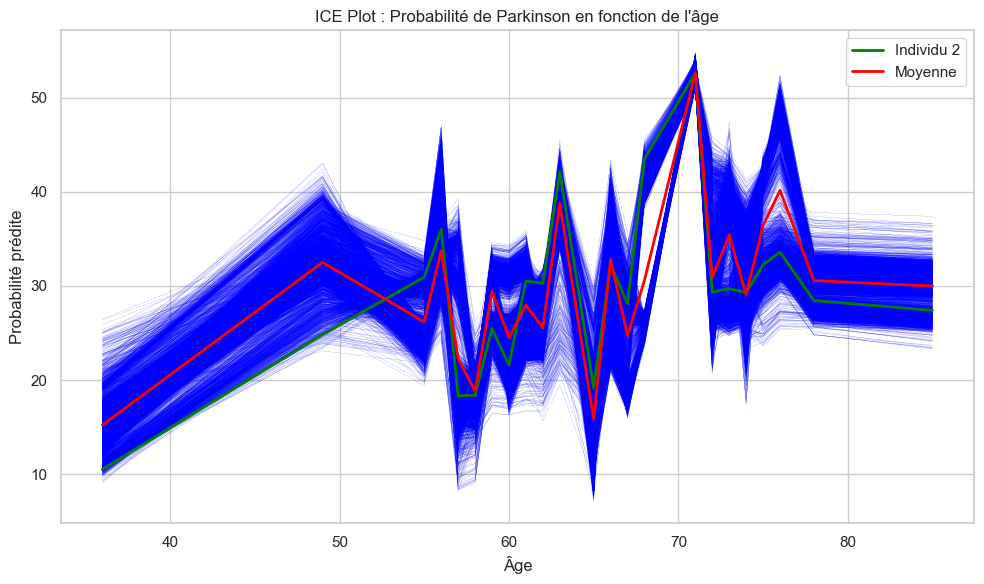

In [28]:
from sklearn.inspection import partial_dependence

# 1. Compute the partial dependence (ICE and average) manually
results = partial_dependence(rf_model, X_train_transformed, features=[0], kind="both", grid_resolution=50)

# Extract values
feature_vals = results['grid_values'][0]
ice_lines = results['individual'][0]   # shape (n_samples, n_grid_points)
average_line = results['average'][0]   # shape (n_grid_points,)

# 2. Plot with Seaborn style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot ICE lines
for row in ice_lines:
    if i == 2:
        continue  # skip individual 2 here; will plot separately in green
    plt.plot(feature_vals, row, color='blue', alpha=0.8, linewidth=0.1)

# Plot the ICE curve for individual 2 in green
plt.plot(feature_vals, ice_lines[2], color='green', linewidth=2, label='Individu 2')

# Plot average (PDP) line in a different color
plt.plot(feature_vals, average_line, color='red', label='Moyenne', linewidth=2)

# 3. Label and show
plt.title("ICE Plot : Probabilité de Parkinson en fonction de l'âge")
plt.xlabel("Âge")
plt.ylabel("Probabilité prédite")
plt.legend()
plt.tight_layout()
plt.show()

#### Comparaison **Pdp** and Average **ICE**


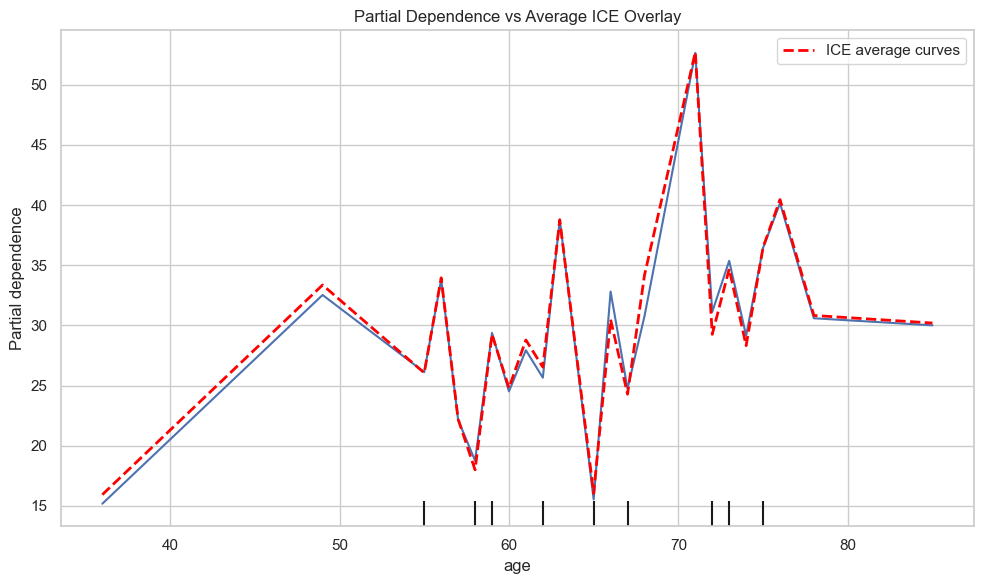

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# Step 1: Plot PDP from pipeline
fig, ax = plt.subplots(figsize=(10, 6))
disp = PartialDependenceDisplay.from_estimator(
    pipeline,
    X_test,
    features=[0],  # single feature
    kind="average",
    grid_resolution=150,
    ax=ax
)
ax = plt.gca()  # get current axis after display

# Step 2: Compute manual PDP from different model/data
results = partial_dependence(rf_model, X_train_transformed, features=[0], kind="average", grid_resolution=150)
feature_vals = results['grid_values'][0]
average_line = results['average'][0]

# Step 3: Access the correct axis and overlay the manual PDP
# If ax is a single Axes object (which it is for one feature), use it directly
ax.plot(
    feature_vals,
    average_line,
    label='ICE average curves',
    color='red',
    linestyle='--',
    linewidth=2
)

# Step 4: Final plot formatting
ax.set_title("Partial Dependence vs Average ICE Overlay")
ax.legend()
plt.tight_layout()
plt.show()


#### **Anchors** - Local

For Anchors, we should turn the problem from a **regression** task to a **classification** one. 

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score

# Binarize total_UPDRS (or your column name)
threshold = df['total_UPDRS'].median()
df['UPDRS_binary'] = (df['total_UPDRS'] > threshold).astype(int)

X_anc = df.drop(columns=['total_UPDRS', 'motor_UPDRS', 'UPDRS_binary'])  # drop targets
y_anc = df['UPDRS_binary']

# Split des données
X_train_anc, X_test_anc, y_train_anc, y_test_anc = train_test_split(X_anc, y_anc, test_size=0.2, random_state=42)

# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest_Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost_Classifier': XGBClassifier(n_estimators=100, random_state=42)
}

# Entraînement et évaluation
trained_models = {}

for name, model in models.items():
    
    model.fit(X_train_anc, y_train_anc)
    y_pred = model.predict(X_test_anc)
    
    print(f"\n=== {name} ===")
    print(f"Recall score: {(recall_score(y_test_anc, y_pred)):.2f}")
    print(f"F1-Score: {f1_score(y_test_anc, y_pred):.2f}")
    
    trained_models[name] = model


=== LogisticRegression ===
Recall score: 0.60
F1-Score: 0.60

=== RandomForest_Classifier ===
Recall score: 0.92
F1-Score: 0.91

=== XGBoost_Classifier ===
Recall score: 0.93
F1-Score: 0.93



 Règle d'ancrage trouvée :
['age <= 65.00', 'DFA > 0.71', 'RPDE <= 0.54', 'Shimmer:APQ5 > 0.01', 'Shimmer:DDA > 0.03', 'Jitter(%) > 0.01']
prediction :0
 Précision de la règle : 0.96
 Couverture de la règle : 0.01


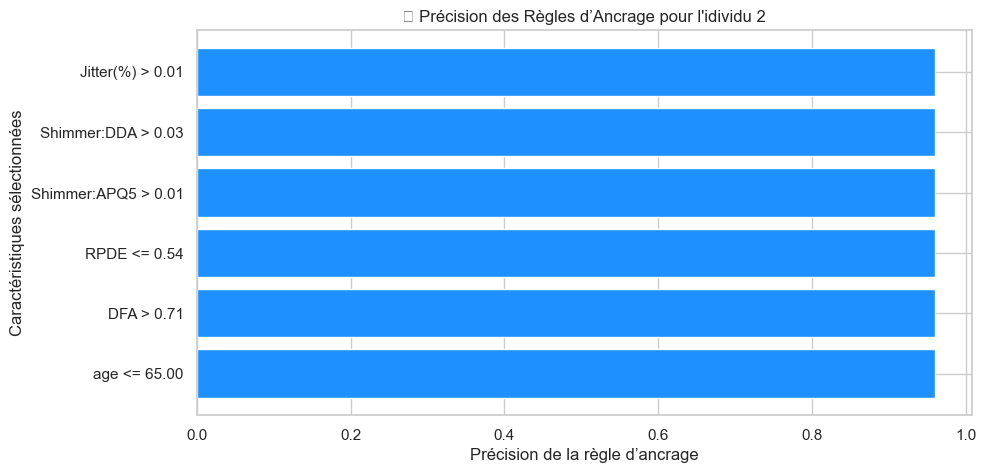

In [31]:
from alibi.explainers import AnchorTabular
rf_model_anc = trained_models['RandomForest_Classifier']
    
# Création de l'explicateur Anchors avec la fonction prédictive
explainer = AnchorTabular(predictor=rf_model_anc.predict, feature_names=X_train_anc.columns)

# Ajustement avec les données d'entraînement
explainer.fit(X_train_anc.to_numpy())

# Sélection d'une instance à expliquer
idx = 2  # Choix d'une instance arbitraire
instance = X_test_anc.iloc[idx].values

# Génération de l'explication avec Anchors
exp_anchor = explainer.explain(instance)

# Affichage de la règle d'ancrage trouvée
print("\n Règle d'ancrage trouvée :")
print(exp_anchor.anchor)
print(f'prediction :{exp_anchor.data['raw']['prediction'][0]}')
print(f" Précision de la règle : {exp_anchor.precision:.2f}")
print(f" Couverture de la règle : {exp_anchor.coverage:.2f}")

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.barh(exp_anchor.data['anchor'], exp_anchor.data['precision'], color="dodgerblue")
plt.xlabel("Précision de la règle d’ancrage")
plt.ylabel("Caractéristiques sélectionnées")
plt.title("🎯 Précision des Règles d’Ancrage pour l'idividu 2")
plt.show()